# Session Data Quality Verification

This notebook verifies the quality of session data by checking:
1. **Spread Anomalies**: Wild or negative spreads
2. **Size Validation**: Incorrect bid/ask sizes
3. **Price Validation**: Price consistency and outliers
4. **Timestamp Validation**: Gaps and irregularities
5. **Exchange Data Integrity**: Multi-exchange consistency

In [1]:
import gzip
import struct
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional

# Configuration
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)

# Constants from binary format
BINARY_MAGIC = b'TICK'
BINARY_VERSION_V3 = 3
PRICE_SCALE = 100_000
SIZE_SCALE = 100
TIME_UNIT = 1_000_000

## 1. Binary Data Reader

In [2]:
class SessionDataReader:
    """Reads and parses binary session data files."""
    
    def __init__(self, filepath: Path):
        self.filepath = filepath
        self.metadata = {}
        self.data = None
        
    def read(self) -> pd.DataFrame:
        """Read and decompress binary session file."""
        with gzip.open(self.filepath, 'rb') as f:
            buffer = f.read()
        
        # Parse header
        offset = 0
        magic, version, interval_ms, num_samples, initial_timestamp_us = struct.unpack(
            '<4sHHIQ', buffer[offset:offset+20]
        )
        offset += 20
        
        if magic != BINARY_MAGIC:
            raise ValueError(f"Invalid magic number: {magic}")
        if version != BINARY_VERSION_V3:
            raise ValueError(f"Unsupported version: {version}")
        
        # Parse publisher map
        map_len = struct.unpack('<H', buffer[offset:offset+2])[0]
        offset += 2
        
        publisher_map_str = buffer[offset:offset+map_len].decode('utf-8')
        offset += map_len
        
        # Parse publisher map
        publisher_map = {}
        for item in publisher_map_str.split(','):
            idx, pub_id = item.split(':')
            publisher_map[int(idx)] = int(pub_id)
        
        # Store metadata
        self.metadata = {
            'version': version,
            'interval_ms': interval_ms,
            'num_samples': num_samples,
            'initial_timestamp_us': initial_timestamp_us,
            'publisher_map': publisher_map,
            'file_size_bytes': len(buffer)
        }
        
        # Parse samples
        records = []
        timestamp_ms = initial_timestamp_us // 1000
        
        for i in range(num_samples):
            # Parse NBBO data
            time_delta_ms, nbbo_bid, nbbo_ask, nbbo_bid_size, nbbo_ask_size, best_bid_pub, best_ask_pub = struct.unpack(
                '<iiiiiBB', buffer[offset:offset+22]
            )
            offset += 22
            
            timestamp_ms += time_delta_ms
            
            record = {
                'timestamp': pd.Timestamp(timestamp_ms, unit='ms'),
                'nbbo_bid': nbbo_bid / PRICE_SCALE,
                'nbbo_ask': nbbo_ask / PRICE_SCALE,
                'nbbo_bid_size': nbbo_bid_size / SIZE_SCALE,
                'nbbo_ask_size': nbbo_ask_size / SIZE_SCALE,
                'nbbo_bid_publisher': publisher_map.get(best_bid_pub, best_bid_pub),
                'nbbo_ask_publisher': publisher_map.get(best_ask_pub, best_ask_pub)
            }
            
            # Parse exchange data
            num_exchanges = struct.unpack('<B', buffer[offset:offset+1])[0]
            offset += 1
            
            for _ in range(num_exchanges):
                pub_idx, bid, ask, bid_size, ask_size = struct.unpack(
                    '<BiiII', buffer[offset:offset+17]
                )
                offset += 17
                
                pub_id = publisher_map.get(pub_idx, pub_idx)
                record[f'ex_{pub_id}_bid'] = bid / PRICE_SCALE
                record[f'ex_{pub_id}_ask'] = ask / PRICE_SCALE
                record[f'ex_{pub_id}_bid_size'] = bid_size / SIZE_SCALE
                record[f'ex_{pub_id}_ask_size'] = ask_size / SIZE_SCALE
            
            records.append(record)
        
        self.data = pd.DataFrame(records)
        return self.data
    
    def get_info(self) -> Dict:
        """Get file metadata."""
        return self.metadata

## 2. Data Quality Checks

In [3]:
class DataQualityChecker:
    """Performs comprehensive data quality checks on session data."""
    
    def __init__(self, df: pd.DataFrame, metadata: Dict):
        self.df = df.copy()
        self.metadata = metadata
        self.issues = []
        
    def check_spreads(self, max_spread_pct: float = 2.0, warn_spread_pct: float = 0.5) -> Dict:
        """Check for negative or excessively wide spreads."""
        print("\n" + "="*80)
        print("SPREAD QUALITY CHECK")
        print("="*80)
        
        self.df['spread'] = self.df['nbbo_ask'] - self.df['nbbo_bid']
        self.df['spread_pct'] = (self.df['spread'] / self.df['nbbo_bid']) * 100
        self.df['mid_price'] = (self.df['nbbo_bid'] + self.df['nbbo_ask']) / 2
        
        # Check for negative spreads (crossed market)
        negative_spreads = self.df[self.df['spread'] < 0]
        
        # Check for zero spreads
        zero_spreads = self.df[self.df['spread'] == 0]
        
        # Check for excessively wide spreads
        wide_spreads = self.df[self.df['spread_pct'] > max_spread_pct]
        
        # Check for warning-level spreads
        warn_spreads = self.df[
            (self.df['spread_pct'] > warn_spread_pct) & 
            (self.df['spread_pct'] <= max_spread_pct)
        ]
        
        results = {
            'total_samples': len(self.df),
            'negative_spreads': len(negative_spreads),
            'zero_spreads': len(zero_spreads),
            'wide_spreads': len(wide_spreads),
            'warn_spreads': len(warn_spreads),
            'min_spread': self.df['spread'].min(),
            'max_spread': self.df['spread'].max(),
            'mean_spread': self.df['spread'].mean(),
            'median_spread': self.df['spread'].median(),
            'std_spread': self.df['spread'].std(),
            'min_spread_pct': self.df['spread_pct'].min(),
            'max_spread_pct': self.df['spread_pct'].max(),
            'mean_spread_pct': self.df['spread_pct'].mean(),
        }
        
        print(f"Total samples: {results['total_samples']:,}")
        print(f"\nSpread Statistics:")
        print(f"  Min spread: ${results['min_spread']:.4f} ({results['min_spread_pct']:.4f}%)")
        print(f"  Max spread: ${results['max_spread']:.4f} ({results['max_spread_pct']:.4f}%)")
        print(f"  Mean spread: ${results['mean_spread']:.4f} ({results['mean_spread_pct']:.4f}%)")
        print(f"  Median spread: ${results['median_spread']:.4f}")
        print(f"  Std spread: ${results['std_spread']:.4f}")
        
        # Report issues
        if results['negative_spreads'] > 0:
            pct = (results['negative_spreads'] / results['total_samples']) * 100
            print(f"\n❌ CRITICAL: {results['negative_spreads']:,} negative spreads ({pct:.2f}%)")
            self.issues.append(f"Negative spreads: {results['negative_spreads']}")
            print("\nSample negative spreads:")
            print(negative_spreads[['timestamp', 'nbbo_bid', 'nbbo_ask', 'spread']].head(10))
        
        if results['zero_spreads'] > 0:
            pct = (results['zero_spreads'] / results['total_samples']) * 100
            print(f"\n⚠️  WARNING: {results['zero_spreads']:,} zero spreads ({pct:.2f}%)")
        
        if results['wide_spreads'] > 0:
            pct = (results['wide_spreads'] / results['total_samples']) * 100
            print(f"\n❌ CRITICAL: {results['wide_spreads']:,} excessively wide spreads >{max_spread_pct}% ({pct:.2f}%)")
            self.issues.append(f"Wide spreads: {results['wide_spreads']}")
            print("\nSample wide spreads:")
            print(wide_spreads[['timestamp', 'nbbo_bid', 'nbbo_ask', 'spread', 'spread_pct']].head(10))
        
        if results['warn_spreads'] > 0:
            pct = (results['warn_spreads'] / results['total_samples']) * 100
            print(f"\n⚠️  WARNING: {results['warn_spreads']:,} wide spreads >{warn_spread_pct}% ({pct:.2f}%)")
        
        if results['negative_spreads'] == 0 and results['wide_spreads'] == 0:
            print("\n✅ PASS: No critical spread issues detected")
        
        return results
    
    def check_sizes(self, min_size: float = 1, max_size: float = 1_000_000) -> Dict:
        """Check for invalid bid/ask sizes."""
        print("\n" + "="*80)
        print("SIZE QUALITY CHECK")
        print("="*80)
        
        # Check NBBO sizes
        zero_bid_size = self.df[self.df['nbbo_bid_size'] == 0]
        zero_ask_size = self.df[self.df['nbbo_ask_size'] == 0]
        negative_bid_size = self.df[self.df['nbbo_bid_size'] < 0]
        negative_ask_size = self.df[self.df['nbbo_ask_size'] < 0]
        too_small_bid = self.df[(self.df['nbbo_bid_size'] > 0) & (self.df['nbbo_bid_size'] < min_size)]
        too_small_ask = self.df[(self.df['nbbo_ask_size'] > 0) & (self.df['nbbo_ask_size'] < min_size)]
        too_large_bid = self.df[self.df['nbbo_bid_size'] > max_size]
        too_large_ask = self.df[self.df['nbbo_ask_size'] > max_size]
        
        results = {
            'total_samples': len(self.df),
            'zero_bid_size': len(zero_bid_size),
            'zero_ask_size': len(zero_ask_size),
            'negative_bid_size': len(negative_bid_size),
            'negative_ask_size': len(negative_ask_size),
            'too_small_bid': len(too_small_bid),
            'too_small_ask': len(too_small_ask),
            'too_large_bid': len(too_large_bid),
            'too_large_ask': len(too_large_ask),
            'min_bid_size': self.df['nbbo_bid_size'].min(),
            'max_bid_size': self.df['nbbo_bid_size'].max(),
            'mean_bid_size': self.df['nbbo_bid_size'].mean(),
            'min_ask_size': self.df['nbbo_ask_size'].min(),
            'max_ask_size': self.df['nbbo_ask_size'].max(),
            'mean_ask_size': self.df['nbbo_ask_size'].mean(),
        }
        
        print(f"Total samples: {results['total_samples']:,}")
        print(f"\nBid Size Statistics:")
        print(f"  Min: {results['min_bid_size']:,.2f}")
        print(f"  Max: {results['max_bid_size']:,.2f}")
        print(f"  Mean: {results['mean_bid_size']:,.2f}")
        print(f"\nAsk Size Statistics:")
        print(f"  Min: {results['min_ask_size']:,.2f}")
        print(f"  Max: {results['max_ask_size']:,.2f}")
        print(f"  Mean: {results['mean_ask_size']:,.2f}")
        
        # Report issues
        if results['negative_bid_size'] > 0 or results['negative_ask_size'] > 0:
            print(f"\n❌ CRITICAL: Negative sizes detected")
            print(f"  Negative bid sizes: {results['negative_bid_size']:,}")
            print(f"  Negative ask sizes: {results['negative_ask_size']:,}")
            self.issues.append("Negative sizes detected")
        
        if results['zero_bid_size'] > 0 or results['zero_ask_size'] > 0:
            pct_bid = (results['zero_bid_size'] / results['total_samples']) * 100
            pct_ask = (results['zero_ask_size'] / results['total_samples']) * 100
            print(f"\n⚠️  WARNING: Zero sizes detected")
            print(f"  Zero bid sizes: {results['zero_bid_size']:,} ({pct_bid:.2f}%)")
            print(f"  Zero ask sizes: {results['zero_ask_size']:,} ({pct_ask:.2f}%)")
        
        if results['too_large_bid'] > 0 or results['too_large_ask'] > 0:
            print(f"\n⚠️  WARNING: Unusually large sizes detected (>{max_size:,})")
            print(f"  Large bid sizes: {results['too_large_bid']:,}")
            print(f"  Large ask sizes: {results['too_large_ask']:,}")
        
        if (results['negative_bid_size'] == 0 and results['negative_ask_size'] == 0 and
            results['zero_bid_size'] == 0 and results['zero_ask_size'] == 0):
            print("\n✅ PASS: No critical size issues detected")
        
        return results
    
    def check_prices(self, max_price_jump_pct: float = 5.0) -> Dict:
        """Check for price anomalies and outliers."""
        print("\n" + "="*80)
        print("PRICE QUALITY CHECK")
        print("="*80)
        
        # Calculate price changes
        self.df['mid_price_change'] = self.df['mid_price'].diff()
        self.df['mid_price_change_pct'] = (self.df['mid_price_change'] / self.df['mid_price'].shift(1)) * 100
        
        # Check for zero or negative prices
        zero_bid = self.df[self.df['nbbo_bid'] <= 0]
        zero_ask = self.df[self.df['nbbo_ask'] <= 0]
        
        # Check for large price jumps
        large_jumps = self.df[abs(self.df['mid_price_change_pct']) > max_price_jump_pct]
        
        # Price statistics
        results = {
            'total_samples': len(self.df),
            'zero_or_negative_bid': len(zero_bid),
            'zero_or_negative_ask': len(zero_ask),
            'large_price_jumps': len(large_jumps),
            'min_bid': self.df['nbbo_bid'].min(),
            'max_bid': self.df['nbbo_bid'].max(),
            'mean_bid': self.df['nbbo_bid'].mean(),
            'min_ask': self.df['nbbo_ask'].min(),
            'max_ask': self.df['nbbo_ask'].max(),
            'mean_ask': self.df['nbbo_ask'].mean(),
            'min_mid': self.df['mid_price'].min(),
            'max_mid': self.df['mid_price'].max(),
            'mean_mid': self.df['mid_price'].mean(),
            'max_price_change_pct': abs(self.df['mid_price_change_pct']).max(),
        }
        
        print(f"Total samples: {results['total_samples']:,}")
        print(f"\nPrice Range:")
        print(f"  Bid: ${results['min_bid']:.2f} - ${results['max_bid']:.2f} (mean: ${results['mean_bid']:.2f})")
        print(f"  Ask: ${results['min_ask']:.2f} - ${results['max_ask']:.2f} (mean: ${results['mean_ask']:.2f})")
        print(f"  Mid: ${results['min_mid']:.2f} - ${results['max_mid']:.2f} (mean: ${results['mean_mid']:.2f})")
        print(f"\nMax price jump: {results['max_price_change_pct']:.2f}%")
        
        # Report issues
        if results['zero_or_negative_bid'] > 0 or results['zero_or_negative_ask'] > 0:
            print(f"\n❌ CRITICAL: Zero or negative prices detected")
            print(f"  Zero/negative bid: {results['zero_or_negative_bid']:,}")
            print(f"  Zero/negative ask: {results['zero_or_negative_ask']:,}")
            self.issues.append("Zero or negative prices")
        
        if results['large_price_jumps'] > 0:
            pct = (results['large_price_jumps'] / results['total_samples']) * 100
            print(f"\n⚠️  WARNING: {results['large_price_jumps']:,} large price jumps >{max_price_jump_pct}% ({pct:.2f}%)")
            print("\nSample large jumps:")
            print(large_jumps[['timestamp', 'mid_price', 'mid_price_change', 'mid_price_change_pct']].head(10))
        
        if results['zero_or_negative_bid'] == 0 and results['zero_or_negative_ask'] == 0:
            print("\n✅ PASS: No critical price issues detected")
        
        return results
    
    def check_timestamps(self) -> Dict:
        """Check for timestamp anomalies and gaps."""
        print("\n" + "="*80)
        print("TIMESTAMP QUALITY CHECK")
        print("="*80)
        
        expected_interval_ms = self.metadata['interval_ms']
        
        # Calculate time deltas
        self.df['time_delta'] = self.df['timestamp'].diff()
        self.df['time_delta_ms'] = self.df['time_delta'].dt.total_seconds() * 1000
        
        # Find gaps (missing intervals)
        gaps = self.df[self.df['time_delta_ms'] > expected_interval_ms * 1.5]
        
        # Find duplicates or backwards timestamps
        duplicates = self.df[self.df['time_delta_ms'] == 0]
        backwards = self.df[self.df['time_delta_ms'] < 0]
        
        results = {
            'total_samples': len(self.df),
            'expected_interval_ms': expected_interval_ms,
            'gaps': len(gaps),
            'duplicates': len(duplicates),
            'backwards': len(backwards),
            'min_interval_ms': self.df['time_delta_ms'].min(),
            'max_interval_ms': self.df['time_delta_ms'].max(),
            'mean_interval_ms': self.df['time_delta_ms'].mean(),
            'start_time': self.df['timestamp'].iloc[0],
            'end_time': self.df['timestamp'].iloc[-1],
            'duration': self.df['timestamp'].iloc[-1] - self.df['timestamp'].iloc[0]
        }
        
        print(f"Total samples: {results['total_samples']:,}")
        print(f"Expected interval: {results['expected_interval_ms']} ms")
        print(f"\nTime Range:")
        print(f"  Start: {results['start_time']}")
        print(f"  End: {results['end_time']}")
        print(f"  Duration: {results['duration']}")
        print(f"\nInterval Statistics:")
        print(f"  Min: {results['min_interval_ms']:.2f} ms")
        print(f"  Max: {results['max_interval_ms']:.2f} ms")
        print(f"  Mean: {results['mean_interval_ms']:.2f} ms")
        
        # Report issues
        if results['backwards'] > 0:
            print(f"\n❌ CRITICAL: {results['backwards']:,} backwards timestamps detected")
            self.issues.append(f"Backwards timestamps: {results['backwards']}")
        
        if results['duplicates'] > 0:
            print(f"\n⚠️  WARNING: {results['duplicates']:,} duplicate timestamps detected")
        
        if results['gaps'] > 0:
            pct = (results['gaps'] / results['total_samples']) * 100
            print(f"\n⚠️  WARNING: {results['gaps']:,} time gaps detected ({pct:.2f}%)")
            print("\nLargest gaps:")
            print(gaps[['timestamp', 'time_delta', 'time_delta_ms']].nlargest(10, 'time_delta_ms'))
        
        if results['backwards'] == 0 and results['duplicates'] == 0:
            print("\n✅ PASS: No critical timestamp issues detected")
        
        return results
    
    def check_exchange_data(self) -> Dict:
        """Check exchange-specific data quality."""
        print("\n" + "="*80)
        print("EXCHANGE DATA QUALITY CHECK")
        print("="*80)
        
        # Find exchange columns
        exchange_cols = [col for col in self.df.columns if col.startswith('ex_')]
        publishers = list(self.metadata['publisher_map'].values())
        
        exchange_stats = {}
        
        for pub_id in publishers:
            bid_col = f'ex_{pub_id}_bid'
            ask_col = f'ex_{pub_id}_ask'
            
            if bid_col not in self.df.columns or ask_col not in self.df.columns:
                continue
            
            # Count non-null values
            bid_count = self.df[bid_col].notna().sum()
            ask_count = self.df[ask_col].notna().sum()
            
            # Check for crossed quotes
            ex_df = self.df[[bid_col, ask_col]].dropna()
            if len(ex_df) > 0:
                crossed = ex_df[ex_df[bid_col] > ex_df[ask_col]]
                
                exchange_stats[pub_id] = {
                    'bid_quotes': bid_count,
                    'ask_quotes': ask_count,
                    'coverage_pct': (bid_count / len(self.df)) * 100,
                    'crossed_quotes': len(crossed)
                }
        
        results = {
            'total_samples': len(self.df),
            'num_exchanges': len(publishers),
            'exchange_stats': exchange_stats
        }
        
        print(f"Total samples: {results['total_samples']:,}")
        print(f"Number of exchanges: {results['num_exchanges']}")
        print(f"\nExchange Coverage:")
        
        for pub_id, stats in exchange_stats.items():
            print(f"\n  Publisher {pub_id}:")
            print(f"    Bid quotes: {stats['bid_quotes']:,} ({stats['coverage_pct']:.1f}%)")
            print(f"    Ask quotes: {stats['ask_quotes']:,}")
            if stats['crossed_quotes'] > 0:
                print(f"    ❌ Crossed quotes: {stats['crossed_quotes']:,}")
                self.issues.append(f"Publisher {pub_id}: {stats['crossed_quotes']} crossed quotes")
        
        print("\n✅ PASS: Exchange data check complete")
        
        return results
    
    def generate_report(self) -> Dict:
        """Run all checks and generate comprehensive report."""
        print("\n" + "="*80)
        print("DATA QUALITY VERIFICATION REPORT")
        print("="*80)
        
        # Run all checks
        spread_results = self.check_spreads()
        size_results = self.check_sizes()
        price_results = self.check_prices()
        timestamp_results = self.check_timestamps()
        exchange_results = self.check_exchange_data()
        
        # Summary
        print("\n" + "="*80)
        print("SUMMARY")
        print("="*80)
        
        if len(self.issues) == 0:
            print("\n✅ ALL CHECKS PASSED - Data quality is excellent!")
        else:
            print(f"\n❌ {len(self.issues)} ISSUE(S) DETECTED:")
            for i, issue in enumerate(self.issues, 1):
                print(f"  {i}. {issue}")
        
        return {
            'spread_results': spread_results,
            'size_results': size_results,
            'price_results': price_results,
            'timestamp_results': timestamp_results,
            'exchange_results': exchange_results,
            'issues': self.issues
        }

## 3. Visualization Functions

In [4]:
def plot_quality_analysis(df: pd.DataFrame, results: Dict):
    """Create comprehensive visualization of data quality."""
    
    fig, axes = plt.subplots(3, 2, figsize=(18, 12))
    fig.suptitle('Session Data Quality Analysis', fontsize=16, fontweight='bold')
    
    # 1. Price and spread over time
    ax1 = axes[0, 0]
    ax1.plot(df['timestamp'], df['mid_price'], label='Mid Price', alpha=0.7)
    ax1.fill_between(df['timestamp'], df['nbbo_bid'], df['nbbo_ask'], alpha=0.3, label='Spread')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Price ($)')
    ax1.set_title('Price and Spread Over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Spread distribution
    ax2 = axes[0, 1]
    ax2.hist(df['spread'], bins=50, edgecolor='black', alpha=0.7)
    ax2.axvline(df['spread'].mean(), color='r', linestyle='--', label=f'Mean: ${df["spread"].mean():.4f}')
    ax2.axvline(df['spread'].median(), color='g', linestyle='--', label=f'Median: ${df["spread"].median():.4f}')
    ax2.set_xlabel('Spread ($)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Spread Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Spread percentage over time
    ax3 = axes[1, 0]
    ax3.plot(df['timestamp'], df['spread_pct'], alpha=0.7)
    ax3.axhline(0.5, color='orange', linestyle='--', alpha=0.5, label='0.5% threshold')
    ax3.axhline(2.0, color='red', linestyle='--', alpha=0.5, label='2.0% threshold')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Spread (%)')
    ax3.set_title('Spread Percentage Over Time')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Size distribution
    ax4 = axes[1, 1]
    ax4.hist(df['nbbo_bid_size'], bins=50, alpha=0.5, label='Bid Size', edgecolor='black')
    ax4.hist(df['nbbo_ask_size'], bins=50, alpha=0.5, label='Ask Size', edgecolor='black')
    ax4.set_xlabel('Size (shares)')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Bid/Ask Size Distribution')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Price change distribution
    ax5 = axes[2, 0]
    price_changes = df['mid_price_change_pct'].dropna()
    ax5.hist(price_changes, bins=100, edgecolor='black', alpha=0.7)
    ax5.axvline(0, color='black', linestyle='-', linewidth=2)
    ax5.axvline(price_changes.mean(), color='r', linestyle='--', label=f'Mean: {price_changes.mean():.4f}%')
    ax5.set_xlabel('Price Change (%)')
    ax5.set_ylabel('Frequency')
    ax5.set_title('Price Change Distribution')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Time interval distribution
    ax6 = axes[2, 1]
    time_deltas = df['time_delta_ms'].dropna()
    ax6.hist(time_deltas, bins=50, edgecolor='black', alpha=0.7)
    expected_interval = results['timestamp_results']['expected_interval_ms']
    ax6.axvline(expected_interval, color='r', linestyle='--', label=f'Expected: {expected_interval} ms')
    ax6.axvline(time_deltas.mean(), color='g', linestyle='--', label=f'Mean: {time_deltas.mean():.2f} ms')
    ax6.set_xlabel('Time Interval (ms)')
    ax6.set_ylabel('Frequency')
    ax6.set_title('Time Interval Distribution')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 4. Load and Verify Session Data

**Instructions:**
1. Update the `session_file` path below to point to your session binary file
2. Run all cells to perform data quality verification
3. Review the detailed report and visualizations

In [5]:
# Configure session file to verify
sessions_dir = Path('../sessions')

# List available session files
session_files = list(sessions_dir.glob('*.bin.gz'))
print(f"Found {len(session_files)} session files:")
for i, f in enumerate(session_files, 1):
    print(f"  {i}. {f.name}")

# Select a session file (change index as needed)
if session_files:
    session_file = session_files[0]  # First file
    print(f"\nSelected: {session_file.name}")
else:
    print("\nNo session files found. Please run get_sessions_fixed.py first.")
    session_file = None

Found 7 session files:
  1. AMIX-20251117.bin.gz
  2. CYPH-20251117.bin.gz
  3. GLMD-20251117.bin.gz
  4. KZIA-20251119.bin.gz
  5. MNDR-20251120.bin.gz
  6. OLMA-20251118.bin.gz
  7. SGML-20251117.bin.gz

Selected: AMIX-20251117.bin.gz


In [6]:
# Load session data
if session_file:
    print(f"Loading session data from: {session_file}")
    reader = SessionDataReader(session_file)
    df = reader.read()
    metadata = reader.get_info()
    
    print(f"\nFile Metadata:")
    print(f"  Version: {metadata['version']}")
    print(f"  Interval: {metadata['interval_ms']} ms")
    print(f"  Samples: {metadata['num_samples']:,}")
    print(f"  File size: {metadata['file_size_bytes'] / 1024 / 1024:.2f} MB")
    print(f"  Publishers: {metadata['publisher_map']}")
    
    print(f"\nDataFrame shape: {df.shape}")
    print(f"\nFirst 5 rows:")
    display(df.head())
    
    print(f"\nColumn names:")
    print(df.columns.tolist())

Loading session data from: ..\sessions\AMIX-20251117.bin.gz

File Metadata:
  Version: 3
  Interval: 100 ms
  Samples: 79,198
  File size: 10.68 MB
  Publishers: {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 43}

DataFrame shape: (79198, 35)

First 5 rows:


,timestamp,nbbo_bid,nbbo_ask,nbbo_bid_size,nbbo_ask_size,nbbo_bid_publisher,nbbo_ask_publisher,ex_1_bid,ex_1_ask,ex_1_bid_size,...,ex_5_bid_size,ex_5_ask_size,ex_43_bid,ex_43_ask,ex_43_bid_size,ex_43_ask_size,ex_6_bid,ex_6_ask,ex_6_bid_size,ex_6_ask_size
0,2025-11-17 13:03:00.200,0.9,0.92,13.0,113.0,3,3,0.8776,0.976,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-11-17 13:03:00.300,0.9,0.92,4.0,113.0,3,3,0.8776,0.976,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-11-17 13:03:00.400,0.9,0.92,4.0,113.0,3,3,0.8776,0.976,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-11-17 13:03:00.500,0.9,0.92,4.0,100.0,3,1,0.8300,0.920,700.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-11-17 13:03:00.600,0.9,0.92,4.0,100.0,3,1,0.8300,0.920,700.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Column names:
['timestamp', 'nbbo_bid', 'nbbo_ask', 'nbbo_bid_size', 'nbbo_ask_size', 'nbbo_bid_publisher', 'nbbo_ask_publisher', 'ex_1_bid', 'ex_1_ask', 'ex_1_bid_size', 'ex_1_ask_size', 'ex_3_bid', 'ex_3_ask', 'ex_3_bid_size', 'ex_3_ask_size', 'ex_4_bid', 'ex_4_ask', 'ex_4_bid_size', 'ex_4_ask_size', 'ex_2_bid', 'ex_2_ask', 'ex_2_bid_size', 'ex_2_ask_size', 'ex_5_bid', 'ex_5_ask', 'ex_5_bid_size', 'ex_5_ask_size', 'ex_43_bid', 'ex_43_ask', 'ex_43_bid_size', 'ex_43_ask_size', 'ex_6_bid', 'ex_6_ask', 'ex_6_bid_size', 'ex_6_ask_size']


In [7]:
# Run data quality checks
if session_file and df is not None:
    checker = DataQualityChecker(df, metadata)
    results = checker.generate_report()


DATA QUALITY VERIFICATION REPORT

SPREAD QUALITY CHECK
Total samples: 79,198

Spread Statistics:
  Min spread: $-1.0800 (-54.0000%)
  Max spread: $0.0587 (6.5933%)
  Mean spread: $-0.0610 (-4.8890%)
  Median spread: $-0.0200
  Std spread: $0.1227

❌ CRITICAL: 47,254 negative spreads (59.67%)

Sample negative spreads:
                  timestamp  nbbo_bid  nbbo_ask  spread
87  2025-11-17 13:03:08.900    0.9069    0.9000 -0.0069
88  2025-11-17 13:03:09.000    0.9069    0.9000 -0.0069
89  2025-11-17 13:03:09.100    0.9069    0.9000 -0.0069
277 2025-11-17 13:03:27.900    0.9570    0.9557 -0.0013
278 2025-11-17 13:03:28.000    0.9570    0.9557 -0.0013
279 2025-11-17 13:03:28.100    0.9570    0.9557 -0.0013
280 2025-11-17 13:03:28.200    0.9570    0.9557 -0.0013
282 2025-11-17 13:03:28.400    0.9617    0.9557 -0.0060
385 2025-11-17 13:03:38.700    0.9560    0.9548 -0.0012
386 2025-11-17 13:03:38.800    0.9560    0.9548 -0.0012

⚠️  WARNING: 5,094 zero spreads (6.43%)

❌ CRITICAL: 144 excess

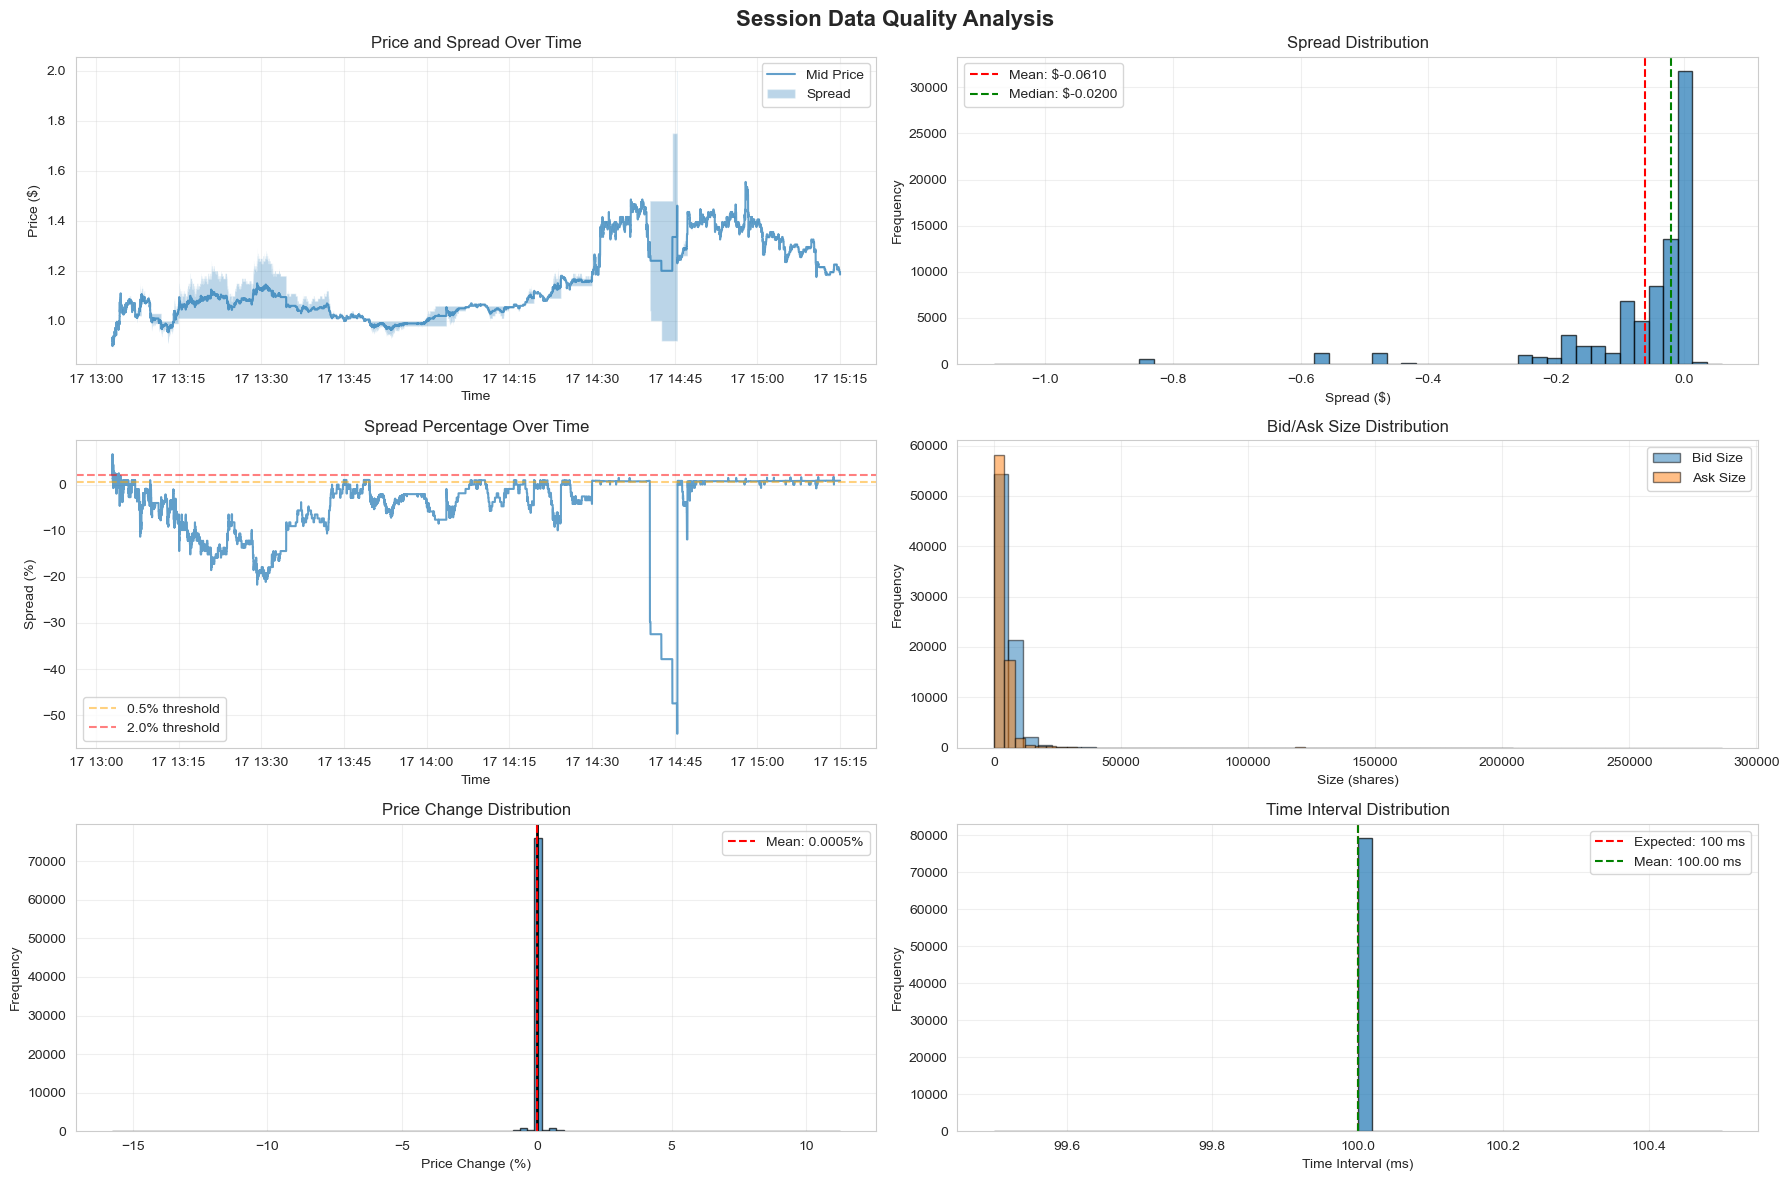

In [8]:
# Create visualizations
if session_file and df is not None:
    plot_quality_analysis(checker.df, results)

## 5. Export Quality Report

Save detailed quality report to CSV for further analysis.

In [ ]:
# Export flagged records
if session_file and df is not None and len(checker.issues) > 0:
    output_dir = Path('../notebook/quality_reports')
    output_dir.mkdir(exist_ok=True)
    
    # Export records with issues
    flagged_df = checker.df[
        (checker.df['spread'] < 0) |  # Negative spreads
        (checker.df['spread_pct'] > 2.0) |  # Wide spreads
        (checker.df['nbbo_bid_size'] <= 0) |  # Invalid bid sizes
        (checker.df['nbbo_ask_size'] <= 0) |  # Invalid ask sizes
        (abs(checker.df['mid_price_change_pct']) > 5.0)  # Large price jumps
    ].copy()
    
    if len(flagged_df) > 0:
        report_file = output_dir / f"{session_file.stem}_quality_issues.csv"
        flagged_df.to_csv(report_file, index=False)
        print(f"Exported {len(flagged_df)} flagged records to: {report_file}")
    else:
        print("No flagged records to export.")
else:
    print("No issues detected or no data loaded.")

## 6. Batch Verification

Verify all session files at once and generate summary report.

In [ ]:
def verify_all_sessions(sessions_dir: Path, output_dir: Path):
    """Verify all session files and generate summary report."""
    session_files = list(sessions_dir.glob('*.bin.gz'))
    
    if not session_files:
        print("No session files found.")
        return
    
    summary = []
    
    for i, session_file in enumerate(session_files, 1):
        print(f"\n{'='*80}")
        print(f"[{i}/{len(session_files)}] Verifying: {session_file.name}")
        print(f"{'='*80}")
        
        try:
            reader = SessionDataReader(session_file)
            df = reader.read()
            metadata = reader.get_info()
            
            checker = DataQualityChecker(df, metadata)
            results = checker.generate_report()
            
            summary.append({
                'file': session_file.name,
                'samples': metadata['num_samples'],
                'negative_spreads': results['spread_results']['negative_spreads'],
                'wide_spreads': results['spread_results']['wide_spreads'],
                'invalid_sizes': results['size_results']['negative_bid_size'] + results['size_results']['negative_ask_size'],
                'large_price_jumps': results['price_results']['large_price_jumps'],
                'timestamp_issues': results['timestamp_results']['backwards'] + results['timestamp_results']['duplicates'],
                'total_issues': len(checker.issues),
                'status': '✅ PASS' if len(checker.issues) == 0 else '❌ FAIL'
            })
            
        except Exception as e:
            print(f"❌ ERROR: Failed to verify {session_file.name}: {e}")
            summary.append({
                'file': session_file.name,
                'samples': 0,
                'negative_spreads': 0,
                'wide_spreads': 0,
                'invalid_sizes': 0,
                'large_price_jumps': 0,
                'timestamp_issues': 0,
                'total_issues': 1,
                'status': '❌ ERROR'
            })
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(summary)
    
    # Save summary
    output_dir.mkdir(exist_ok=True)
    summary_file = output_dir / f"quality_summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    summary_df.to_csv(summary_file, index=False)
    
    # Print summary
    print(f"\n{'='*80}")
    print("BATCH VERIFICATION SUMMARY")
    print(f"{'='*80}")
    print(summary_df.to_string(index=False))
    print(f"\nSummary saved to: {summary_file}")
    
    # Overall statistics
    total_files = len(summary_df)
    passed = len(summary_df[summary_df['status'] == '✅ PASS'])
    failed = len(summary_df[summary_df['status'] == '❌ FAIL'])
    errors = len(summary_df[summary_df['status'] == '❌ ERROR'])
    
    print(f"\nOverall Statistics:")
    print(f"  Total files: {total_files}")
    print(f"  Passed: {passed} ({passed/total_files*100:.1f}%)")
    print(f"  Failed: {failed} ({failed/total_files*100:.1f}%)")
    print(f"  Errors: {errors} ({errors/total_files*100:.1f}%)")
    
    return summary_df

# Run batch verification (uncomment to execute)
summary_df = verify_all_sessions(Path('../sessions'), Path('../notebook/quality_reports'))
summary_df